# Convert Data to .npz

A dataset and adapted notebook from [Priya Dwived, Music Genre Classification](https://github.com/priya-dwivedi/Music_Genre_Classification)

The aim of this notebook is to store the spectogram features into arrays to use later as train, test and validation sets.

## Imports

In [1]:
%matplotlib inline

import os
from utils import utils
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import pandas as pd


In [2]:
plt.rcParams.update({
    "figure.facecolor":  (0.0, 0.0, 0.0, 0.0) # make plot background transparent
})

In [3]:
AUDIO_DIR = 'data/fma_small'

In [4]:
tids = utils.get_tids_from_directory(AUDIO_DIR) # list of track IDs
print(len(tids)) # 8000

8000


### Create spectograms

We'll use the functions `create_spectogram` and `plot_spect` defined in `utils.py`

(646, 128)


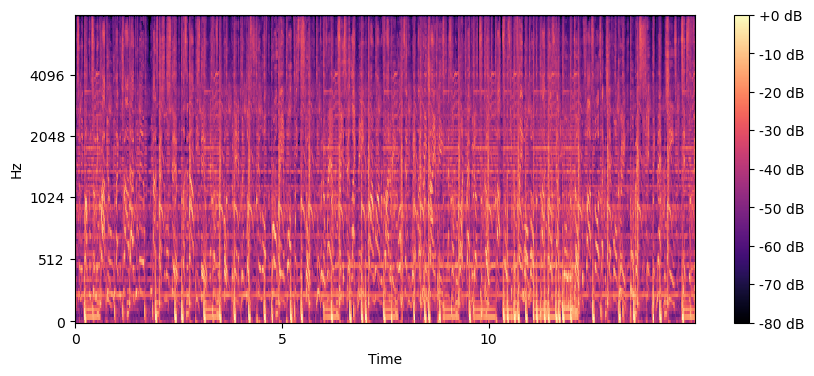

In [5]:
utils.plot_spect(2, AUDIO_DIR) # plot spectogram for track 2

In [6]:
spec = utils.create_spectogram(2, AUDIO_DIR) # create spectogram for track 2
spec.shape # (time frames, frequency bins)

(646, 128)

### Load dataset with genre and track IDs

In [7]:
filepath = 'data/fma_metadata/tracks.csv' # load metadata
tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])  # header=[0, 1] to read multiindex
keep_cols = [('set', 'split'), 
('set', 'subset'),('track', 'genre_top')] # keep only these columns

df_all = tracks[keep_cols]
df_all = df_all[df_all[('set', 'subset')] == 'small'] # keep only small dataset

df_all['track_id'] = df_all.index # add track_id column
df_all.head()

set            track track_id
             split subset genre_top         
track_id                                    
2         training  small   Hip-Hop        2
5         training  small   Hip-Hop        5
10        training  small       Pop       10
140       training  small      Folk      140
141       training  small      Folk      141

In [8]:
df_all.shape 

(8000, 4)

In [9]:
df_all[('track', 'genre_top')].unique()  # list of genres

array(['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International',
       'Electronic', 'Instrumental'], dtype=object)

Create dictionary of genres to map to numbers

In [10]:
dict_genres = {'Electronic':1, 'Experimental':2, 'Folk':3, 'Hip-Hop':4, 
               'Instrumental':5,'International':6, 'Pop' :7, 'Rock': 8  }

### Create train, validation and test subsets

We have training, validation and test splits in the dataset.

In [11]:
df_all[('set', 'split')].unique()

array(['training', 'validation', 'test'], dtype=object)

In [12]:
df_train = df_all[df_all[('set', 'split')]=='training'] 
df_valid = df_all[df_all[('set', 'split')]=='validation']
df_test = df_all[df_all[('set', 'split')]=='test']

print(df_train.shape, df_valid.shape, df_test.shape)

(6400, 4) (800, 4) (800, 4)


As seen, the training set has 6400 tracks and the validation and test sets 800 each

### Create Arrays

Create a function that given a dataset of tracks, it computes the spectogram for each track and stores this data into an array

In [13]:
def create_array(df): 
    genres = []
    X_spect = np.empty((0, 640, 128)) # X_spect is an empty array with 3 dimensions
    count = 0

    
    for index, row in df.iterrows(): # iterate through each row of df
        try:
            count += 1  # keep track of processed tracks
            track_id = int(row['track_id']) # get track_id from row
            genre = str(row[('track', 'genre_top')]) # get genre from row
            spect = utils.create_spectogram(track_id) # create spectogram for that track
    
            # Normalize for small shape differences
            spect = spect[:640, :] # keep only first 640 columns    
            X_spect = np.append(X_spect, [spect], axis=0) # append spect to X_spect array
            genres.append(dict_genres[genre]) # append genre to genres list
            
            if count % 100 == 0: # print every 100 files
                print("Currently processing: ", count)
        except:
            print("Couldn't process: ", count)
            continue
    y_arr = np.array(genres)
    return X_spect, y_arr  #return the array of spectograms and the array of genres

Create arrays X and y for each subset (train, test and validation) using the `create_array()` function.

In [17]:
X_test, y_test = create_array(df_test)

Currently processing:  100
Currently processing:  200
Currently processing:  300
Currently processing:  400
Currently processing:  500
Currently processing:  600
Currently processing:  700
Currently processing:  800


In [18]:
print(X_test.shape, y_test.shape)

(800, 640, 128) (800,)


In [19]:
print(y_test[:23])

[8 6 6 6 6 6 6 3 3 2 2 2 2 2 2 8 8 2 2 2 2 2 2]


In [20]:
np.savez('test_arr', X_test, y_test)

In [21]:
X_valid, y_valid = create_array(df_valid)

Currently processing:  100
Currently processing:  200
Currently processing:  300
Currently processing:  400
Currently processing:  500
Currently processing:  600
Currently processing:  700
Currently processing:  800


In [22]:
np.savez('valid_arr', X_valid, y_valid)

For the train data, we'll split into 4 chunks to do the slow pre-processing in phases

In [23]:
def splitDataFrameIntoSmaller(df, chunkSize = 1600): 
    listOfDf = list()
    numberChunks = len(df) // chunkSize + 1
    for i in range(numberChunks):
        listOfDf.append(df[i*chunkSize:(i+1)*chunkSize])
    return listOfDf

In [24]:
listDf = splitDataFrameIntoSmaller(df_train)
df1_train = listDf[0]
df2_train = listDf[1]
df3_train = listDf[2]
df4_train = listDf[3]
print(df1_train.shape, df2_train.shape, df3_train.shape, df4_train.shape)

(1600, 4) (1600, 4) (1600, 4) (1600, 4)


In [25]:
X_train1, y_train1 = create_array(df1_train)

Currently processing:  100
Currently processing:  200
Currently processing:  300


[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!


Currently processing:  400
Currently processing:  500
Currently processing:  600


[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!


Currently processing:  700
Currently processing:  800
Currently processing:  900


[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!


Currently processing:  1000
Currently processing:  1100
Currently processing:  1200
Currently processing:  1300
Currently processing:  1400
Currently processing:  1500
Currently processing:  1600


In [26]:
np.savez('train1_arr', X_train1, y_train1)

In [27]:
X_train2, y_train2 = create_array(df2_train)

Currently processing:  100


[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3360) too large for available bit count (3240)
[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3328) too large for available bit count (3240)


Currently processing:  200
Currently processing:  300
Currently processing:  400
Currently processing:  500
Currently processing:  600
Currently processing:  700
Currently processing:  800
Currently processing:  900
Currently processing:  1000
Currently processing:  1100
Currently processing:  1200
Currently processing:  1300
Currently processing:  1400
Currently processing:  1500
Currently processing:  1600


In [28]:
np.savez('train2_arr', X_train2, y_train2)

In [29]:
X_train3, y_train3 = create_array(df3_train)

Currently processing:  100
Currently processing:  200


Note: Illegal Audio-MPEG-Header 0x00000000 at offset 33361.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1365] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
/tmp/ipykernel_20341/2902233345.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filename)
/anaconda/envs/pytorch/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Couldn't process:  296
Couldn't process:  297
Couldn't process:  298


Note: Illegal Audio-MPEG-Header 0x00000000 at offset 22401.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1365] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
/tmp/ipykernel_20341/2902233345.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filename)
/anaconda/envs/pytorch/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
Note: Illegal Audio-MPEG-Header 0x00000000 at offset 63168.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1365] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe 

Currently processing:  300


[src/libmpg123/parse.c:do_readahead():1099] warning: Cannot read next header, a one-frame stream? Duh...
/tmp/ipykernel_20341/2902233345.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filename)
/anaconda/envs/pytorch/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Couldn't process:  331
Currently processing:  400
Currently processing:  500
Currently processing:  600


[src/libmpg123/parse.c:do_readahead():1099] warning: Cannot read next header, a one-frame stream? Duh...
/tmp/ipykernel_20341/2902233345.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filename)
/anaconda/envs/pytorch/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Couldn't process:  698
Currently processing:  700
Currently processing:  800
Currently processing:  900
Currently processing:  1000
Currently processing:  1100
Currently processing:  1200
Currently processing:  1300
Currently processing:  1400
Currently processing:  1500
Currently processing:  1600


In [30]:
print(X_train3.shape, y_train3.shape)

(1595, 640, 128) (1595,)


In [31]:
np.savez('train3_arr', X_train3, y_train3)

In [32]:
X_train4, y_train4 = create_array(df4_train)

Currently processing:  100
Currently processing:  200
Currently processing:  300
Currently processing:  400
Currently processing:  500
Currently processing:  600
Currently processing:  700
Currently processing:  800


/tmp/ipykernel_20341/2902233345.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filename)
[src/libmpg123/parse.c:do_readahead():1099] warning: Cannot read next header, a one-frame stream? Duh...
/anaconda/envs/pytorch/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Couldn't process:  812
Currently processing:  900
Currently processing:  1000
Currently processing:  1100
Currently processing:  1200
Currently processing:  1300
Currently processing:  1400
Currently processing:  1500
Currently processing:  1600


In [33]:
np.savez('train4_arr', X_train4, y_train4)

In [34]:
print(X_train4.shape, y_train4.shape)

(1599, 640, 128) (1599,)


### Concatenate and Shuffle data

In [35]:
npzfile = np.load('train1_arr.npz')
print(npzfile.files)
X_train1 = npzfile['arr_0']
y_train1 = npzfile['arr_1']
print(X_train1.shape, y_train1.shape)

['arr_0', 'arr_1']
(1600, 640, 128) (1600,)


In [36]:
npzfile = np.load('train2_arr.npz')
print(npzfile.files)
X_train2 = npzfile['arr_0']
y_train2 = npzfile['arr_1']
print(X_train2.shape, y_train2.shape)

['arr_0', 'arr_1']
(1600, 640, 128) (1600,)


In [37]:
npzfile = np.load('train3_arr.npz')
print(npzfile.files)
X_train3 = npzfile['arr_0']
y_train3 = npzfile['arr_1']
print(X_train3.shape, y_train3.shape)

['arr_0', 'arr_1']
(1595, 640, 128) (1595,)


In [38]:
npzfile = np.load('train4_arr.npz')
print(npzfile.files)
X_train4 = npzfile['arr_0']
y_train4 = npzfile['arr_1']
print(X_train4.shape, y_train4.shape)

['arr_0', 'arr_1']
(1599, 640, 128) (1599,)


In [39]:
npzfile = np.load('valid_arr.npz')
print(npzfile.files)
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


#### Concatenate train data

In [40]:
X_train = np.concatenate((X_train1, X_train2, X_train3, X_train4), axis = 0)
y_train = np.concatenate((y_train1, y_train2, y_train3, y_train4), axis = 0)
print(X_train.shape, y_train.shape)

(6394, 640, 128) (6394,)


In [41]:
## Convert y data from scale 0-7
print(np.amin(X_train), np.amax(X_train), np.mean(X_train))
y_train = y_train -1
y_valid = y_valid -1
print(np.amin(y_train), np.amax(y_train), np.mean(y_train))

-80.0 3.814697265625e-06 -44.05223673318391
0 7 3.500625586487332


In [42]:
### Convert the scale of training data
X_train_raw = librosa.core.db_to_power(X_train, ref=1.0)
print(np.amin(X_train_raw), np.amax(X_train_raw), np.mean(X_train_raw))

1e-08 1.0000008783668917 0.004447215735686752


In [43]:
X_train_log = np.log(X_train_raw)
print(np.amin(X_train_log), np.amax(X_train_log), np.mean(X_train_log))

-18.420680743952367 8.783665059016772e-07 -10.143402361487333


In [44]:
X_valid_raw = librosa.core.db_to_power(X_valid, ref=1.0)
X_valid_log = np.log(X_valid_raw)

In [45]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X_train, y_train = unison_shuffled_copies(X_train_log, y_train)
X_valid, y_valid = unison_shuffled_copies(X_valid_log, y_valid)

In [46]:
print("Shapes are: ", X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

Shapes are:  (6394, 640, 128) (800, 640, 128) (6394,) (800,)


Store arrays into .npz files

In [47]:
np.savez('shuffled_train', X_train, y_train)
np.savez('shuffled_valid', X_valid, y_valid)